In [118]:
import re, os, sys, glob
import numpy as np
import pandas as pd
from PIL import Image
from pprint import pprint
from readimc import MCDFile, TXTFile
from matplotlib import pyplot as plt

import ezomero
from ezomero import rois

In [ ]:
outname = "NP19"
base = "<directory filled with MCD Files>"
testFileHandle = glob.glob(os.path.join(base,outname,"*.mcd"))[0]
image_filename = os.path.join(base,outname,outname+"_scanplan.png")

In [143]:
with MCDFile(testFileHandle) as f:
    num_slides = len(f.slides)
    print("Total Slides: {}".format(num_slides) )
    for slide in f.slides:
        print("  ID = {}, Desc = {}, W:{} x H:{}".format(
            slide.id,
            slide.description,
            slide.width_um, 
            slide.height_um))

Total Slides: 1
  ID = 0, Desc = Slide, W:75000.0 x H:25000.0


In [148]:
with MCDFile(testFileHandle) as f:
    num_ps = len(f.slides[0].panoramas)
    print("Total Panoramas: {}".format(num_ps) )
    for panorama in f.slides[0].panoramas:
        print("  ID = {}, Desc = {}, W:{} x H:{}".format(
            panorama.id,
            panorama.description,
            panorama.width_um, 
            panorama.height_um))
pIdx = 3

Total Panoramas: 5
  ID = 1, Desc = kb WIN_20220902_15_06_40_Pro.jpg, W:75000.0 x H:24242.341999999997
  ID = 2, Desc = Panorama_002, W:11000.0 x H:800.0
  ID = 3, Desc = Panorama_003, W:600.0 x H:9800.0
  ID = 4, Desc = Panorama_004, W:9798.0 x H:4414.0
  ID = 5, Desc = Panorama_005, W:7518.0 x H:1940.0


In [149]:
targetPanoramaDF = {}
with MCDFile(testFileHandle) as f:
    num_ps = len(f.slides[0].panoramas)
    print("Total Panoramas: {}".format(num_ps) )
    targetPanoramaDF = f.slides[0].panoramas[pIdx].metadata
pprint(targetPanoramaDF)

Total Panoramas: 5
{'Description': 'Panorama_004',
 'ID': '4',
 'ImageEndOffset': '61491004',
 'ImageFormat': 'PNG',
 'ImageStartOffset': '15520932',
 'IsLocked': 'true',
 'PixelHeight': '0',
 'PixelScaleCoef': '1',
 'PixelWidth': '0',
 'RotationAngle': '0',
 'SlideID': '0',
 'SlideX1PosUm': '22364',
 'SlideX2PosUm': '32162',
 'SlideX3PosUm': '32162',
 'SlideX4PosUm': '22364',
 'SlideY1PosUm': '19771',
 'SlideY2PosUm': '19771',
 'SlideY3PosUm': '15357',
 'SlideY4PosUm': '15357',
 'Type': 'Instrument'}


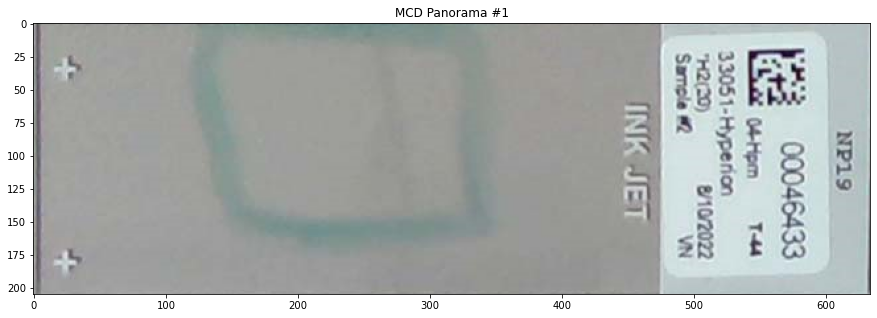

In [150]:
with MCDFile(testFileHandle) as f:
    panorama = f.slides[0].panoramas[0]  # first panorama of first slide
    img = f.read_panorama(panorama)  # numpy array
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    ax.imshow(img) #, vmax=1550)
    ax.set_title('MCD Panorama #1')
    plt.show()

In [154]:
with MCDFile(testFileHandle) as f:
    panoramaTop = f.slides[0].panoramas[3]  # first panorama of first slide
    imgTop = f.read_panorama(panoramaTop)  # numpy array
    print(imgTop.shape)
    panoramaBot = f.slides[0].panoramas[4]  # first panorama of first slide
    imgBot = f.read_panorama(panoramaBot)  # numpy array
    print(imgBot.shape)
    
    #fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    #ax.imshow(img) #, vmax=1550)
    #ax.set_title('MCD Panorama #'+pIdx)
    #plt.show()

(4414, 9798, 4)
(1940, 7518, 4)


In [165]:
blank = np.full((1940, 2280, 4),255)
bottom2 = np.concatenate((imgBot,blank), axis=1)
allPans = np.concatenate((imgTop,bottom2), axis=0)
allPans.shape

(6354, 9798, 4)

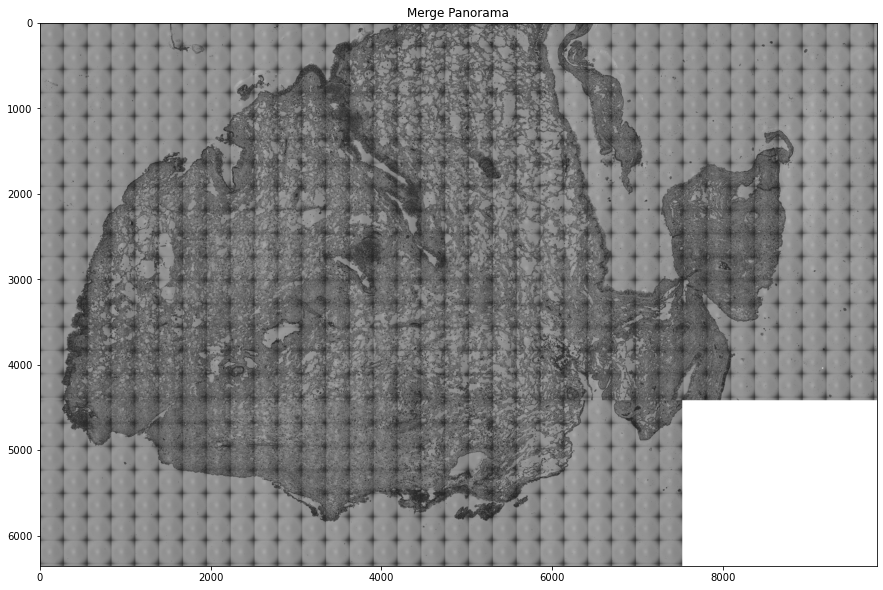

In [166]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(allPans) #, vmax=1550)
ax.set_title('Merge Panorama')
plt.show()

In [176]:
img2 = Image.fromarray(allPans.astype(np.uint8), "RGBA")
# Display the Numpy array as Image
# img2.show()
# Save the Numpy array as Image
img2.save(image_filename)

# Can submit Numpy array directly to OMERO. But requres 5 dim array/OMETIFF format.

In [177]:
allROILocations = []

with MCDFile(testFileHandle) as f:
    num_ps = len(f.slides[0].acquisitions)
    print("Total Acquisitions: {}".format(num_ps) )
    for acquisition in f.slides[0].acquisitions:
        print("  ID = {}, Desc = {}, W:{} x H:{}".format(
            acquisition.id,
            acquisition.description,
            acquisition.width_um, 
            acquisition.height_um))
        #print("Ions: ["+ ",".join(acquisition.channel_names)+"]")
        print("Markers: ["+ ", ".join(acquisition.channel_labels)+"]\n")
        # pprint(acquisition.metadata)
        print("")
        calcX = (float(acquisition.metadata['ROIStartXPosUm'])/1000) - float(targetPanoramaDF["SlideX1PosUm"]) 
        calcY = float(targetPanoramaDF["SlideY1PosUm"]) - (float(acquisition.metadata['ROIStartYPosUm'])/1000) 
        allROILocations.append({"Name":acquisition.description, "width":acquisition.width_um,
                                "height":acquisition.height_um, 
                                "xPosition":calcX,"yPosition":calcY})

Total Acquisitions: 6
  ID = 1, Desc = NP17___46433_001, W:575.0 x H:1130.0
Markers: [131Xe, 141-SMA, 142Nd-CD19, 143Nd-Vimentin, 144Nd-cd14, 145Nd, 146Nd-CD16, 147Sm, 148-Pan-Ker, 149Sm-CD11b, 150Sm, 151Eu-CD123, 152Sm-CD45, 154Sm-CD11c, 155Gd-FoxP3, 156Gd-CD4, 158Gd-E_Cadherin, 159Tb-CD68, 160Gd-Vista, 161Dy-CD20, 162Dy-CD8a, 164Dy-CD141, 165Ho-CD56, 166Er-CD45RA, 167Er-GranzymeB, 168Er-Ki67, 169Tmp-CollagenI, 170Er-CD3, 171Yb-HistoneH3, 172Yb-CD1c, 173Yb-CD45RO, 174Yb-HLA-DR, 175Lu-Beta2M, 176Yb-Nak-ATPase, 190BCKG, 191Ir-NA1, 193Ir-NA2, 195Pt, 202Hg]


  ID = 2, Desc = NP17___46433_002, W:850.0 x H:700.0
Markers: [131Xe, 141-SMA, 142Nd-CD19, 143Nd-Vimentin, 144Nd-cd14, 145Nd, 146Nd-CD16, 147Sm, 148-Pan-Ker, 149Sm-CD11b, 150Sm, 151Eu-CD123, 152Sm-CD45, 154Sm-CD11c, 155Gd-FoxP3, 156Gd-CD4, 158Gd-E_Cadherin, 159Tb-CD68, 160Gd-Vista, 161Dy-CD20, 162Dy-CD8a, 164Dy-CD141, 165Ho-CD56, 166Er-CD45RA, 167Er-GranzymeB, 168Er-Ki67, 169Tmp-CollagenI, 170Er-CD3, 171Yb-HistoneH3, 172Yb-CD1c, 173Y

# UPLOAD TO OMERO!

In [179]:
home = str(Path.home())
config = configparser.RawConfigParser()
config.read(r'{}\Documents\myKeyVariables.cfg'.format(home))   
envVars = dict(config.items('OMERO'))

# Settings for OMERO
user = envVars['user']
password = envVars['pass']
host = envVars['url']
port = 4064 #4080
secure = True #False

conn = ezomero.connect(user, password, 'KB_Lab', host=host, port=port, secure=secure)
### Known Windows specific issue: https://forum.image.sc/t/trouble-connecting-to-omero-server-with-python/46097/6
ezomero.print_projects(conn)

Projects:
	20220906_KB_Hyperion:	151
	20210908_KB_Hyperion:	309


In [180]:
ezomero.print_datasets(conn, project=151)

Datasets in Project "20220906_KB_Hyperion":
	NP17:	204
	NP19:	206
	NP25a:	205


In [181]:
imgs = ezomero.get_image_ids(conn, dataset=206)
for im in imgs:
    imgDesc, pix = ezomero.get_image(conn, im, xyzct=False, no_pixels=True)
    print("{}".format(imgDesc.getName()))
    if "scanplan" in str(imgDesc.getName()):
        print("Found a Scanplan!")
        #shapes = list()
        for rr in allROILocations:
            rectangle = ezomero.rois.Rectangle(x=rr['xPosition'],y=rr['yPosition'],
                                  width=rr['width'],height=rr['height'],z=0,label=rr['Name'])
            ezomero.post_roi(conn, im, [rectangle], fill_color=(73, 218, 67, 30),
             stroke_color=(246, 53, 10, 255), stroke_width=3)

#    shapes.append(rectangle)  

NP19_scanplan.png
Found a Scanplan!
req33051_NP19_46433_NP17___46433_003.ome.tiff
req33051_NP19_46433_NP17___46433_001.ome.tiff
req33051_NP19_46433_NP17___46433_002.ome.tiff
req33051_NP19_46433_NP17___46433_005.ome.tiff
req33051_NP19_46433_NP17___46433_004.ome.tiff
req33051_NP19_46433_NP17___46433_006.ome.tiff
